In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=62e96551ac8e792d7516ec6f354bded1904045d68d606147450fe0d029eb87f0
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [1]:
import sys
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql import Row
from pyspark.mllib.linalg import Vectors


from typing import List, Tuple, Union
from pyspark.rdd import RDD
from math import sqrt
import math


from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col, lit, when
from pyspark.sql.functions import explode
from mpl_toolkits.mplot3d import Axes3D

# Import và chuyển dữ liệu về RDD

In [2]:
spark = SparkSession.builder.appName("HierachicalClustering").getOrCreate()

In [3]:
FILE_PATH = "/content/pca_data.csv"

In [4]:
data = spark.read.csv(FILE_PATH, header=True, inferSchema=True).rdd
data_rdd = data.map(lambda row: Vectors.dense([row[0], row[1], row[2]]))

In [5]:
data_rdd.cache()

PythonRDD[15] at RDD at PythonRDD.scala:53

In [ ]:
data_rdd.take(2)

[DenseVector([-4.689, -0.1611, -2.1505]), DenseVector([2.843, -0.197, 2.0478])]

# MODEL

## DHC


In [16]:
def variance(data):
    # Biến để đếm
    n = data.count()
    # Tính giá trị trung bình
    mean = data.reduce(lambda x, y: x + y) / n
    # Tính phương sai
    var = data.map(lambda x: (x - mean) ** 2).reduce(lambda x, y: x + y) / n
    return var

In [17]:
def variance_based_split(rdd):
    # Biến số lượng thuộc tính trong dữ liệu
    num_features = len(rdd.first()) #3
    # Tính phương sai của các thuộc tính bằng hàm variance
    variances = [variance(rdd.map(lambda x: x[i])) for i in range(num_features)]
    # Xác định thuộc tính với phương sai lớn nhất
    feature_index = variances.index(max(variances))

    # Sort data dựa trên thuộc tinh có phương sai lớn nhất
    sorted_rdd = rdd.sortBy(lambda x: x[feature_index]).zipWithIndex().map(lambda x: (x[1], x[0]))
    count = sorted_rdd.count()

    # Nếu count = 0 thì trả về empty
    if count == 0:
        return rdd, spark.sparkContext.emptyRDD()

   # Thực hiện tính điểm trung vị
    median_index = count // 2
    median_value = sorted_rdd.lookup(median_index)[0][feature_index]

    # Chia dữ liệu làm 2 dựa trên điểm trung vị
    cluster1 = rdd.filter(lambda x: x[feature_index] <= median_value)
    cluster2 = rdd.filter(lambda x: x[feature_index] > median_value)

    return cluster1, cluster2

In [18]:
def divisive_clustering(rdd, max_clusters):
    # Lưu dữ liệu vào một bộ dữ liệu (RDD, label của điểm)
    clusters = [(rdd, 0)]
    # Biến đếm cụm
    cluster_counter = 1
    # Vòng lặp xác định kích thước cụm có bé hơn k cụm
    while len(clusters) < max_clusters:
        # Tạo cụm mới
        new_clusters = []
        # Vòng lặp qua các cụm và nhãn trong clusters
        for cluster, label in clusters:
            # Thực hiện chia dữ liệu nếu kích thược dữ liệu lớn hơn 1
            if cluster.count() > 1:
                # Chia dữ liệu bằng hàm variance_based_split
                c1, c2 = variance_based_split(cluster)
                # Thực hiện thêm vào cụm mới các cụm đã chia
                new_clusters.append((c1, label))
                new_clusters.append((c2, cluster_counter))
                # Tăng biến đếm thêm 1
                cluster_counter += 1
            else:
                # Thực hiện thêm vào cụm mới (cluster, label)
                new_clusters.append((cluster, label))
        # Gán cho biến clusters = new_clusters
        clusters = new_clusters
    return clusters

In [19]:
k = 4
result_dhc = divisive_clustering(data_rdd, k)

## AHC

In [11]:
# Hàm dùng để tính khoảng cách giữa các điểm trong không gian
def p_distance(point1, point2):
    return sum((a - b) ** 2 for a, b in zip(point1, point2))

In [12]:
# Hàm tính độ tăng Phương Sai khi gom 2 cụm lại với nhau
def ward_distance(cluster1, cluster2):
    centroid1, points1 = cluster1
    centroid2, points2 = cluster2
    size1 = len(points1)
    size2 = len(points2)
    total_size = size1 + size2

    var1 = sum(p_distance(point, centroid1) for point in points1)
    var2 = sum(p_distance(point, centroid2) for point in points2)

    merged_centroid = tuple((c1 * size1 + c2 * size2) / total_size for c1, c2 in zip(centroid1, centroid2))
    merged_var = sum(p_distance(point, merged_centroid) for point in points1 + points2)

    increase_in_variance = merged_var - (var1 + var2)
    return increase_in_variance


In [13]:
# Hàm xác định cặp cụm gần nhau nhất
def closest_clusters(cluster_list):
    min_distance = float('inf')
    closest_pair = None

    for i in range(len(cluster_list)):
        for j in range(i + 1, len(cluster_list)):
            dist = ward_distance(cluster_list[i], cluster_list[j])
            if dist < min_distance:
                min_distance = dist
                closest_pair = (cluster_list[i], cluster_list[j])

    return closest_pair

In [14]:
# Hàm thực hiện AHC
def agglomerative_clustering(data_rdd, k):

    # Khởi tạo các cụm tại điểm
    clusters = data_rdd.map(lambda point: (point, [point])).collect()

    while len(clusters) > k:
        # Tìm cặp cụm gần nhau nhất
        closest_pair = closest_clusters(clusters)

        if not closest_pair:
            break

        cluster1, cluster2 = closest_pair

        # Gọp 2 cụm gần nhau nhất lại với nhau
        new_points = cluster1[1] + cluster2[1]
        new_centroid = tuple(sum(x) / len(new_points) for x in zip(*new_points))

        new_cluster = (new_centroid, new_points)

        # Loại bỏ cụm gần nhau nhất khỏi danh sách cụm
        clusters = [cluster for cluster in clusters if cluster != cluster1 and cluster != cluster2]

        # Thêm cụm đã được gọp vào danh sách cụm
        clusters.append(new_cluster)

    return clusters

In [15]:
k = 4
result_ahc = agglomerative_clustering(data_rdd, k)


KeyboardInterrupt: 

# Kết quả

## DHC

In [20]:
for i, cluster in enumerate(result_dhc):
  cluster_rdd, label = cluster
  print(f"Cluster {label} (label: {label}) has {cluster_rdd.count()} points")

Cluster 0 (label: 0) has 554 points
Cluster 2 (label: 2) has 553 points
Cluster 1 (label: 1) has 554 points
Cluster 3 (label: 3) has 551 points


In [21]:
cluster_data = []
for i, cluster_tuple in enumerate(result_dhc):
    cluster_rdd, label = cluster_tuple
    cluster_data.extend([(row.tolist(), label) for row in cluster_rdd.collect()])


In [ ]:
cluster_data

[([-4.688990299, -0.161059582, -2.150476907], 0),
 ([-2.508281353, 0.8519421916573712, 0.1633727577626868], 0),
 ([-3.898882282, 1.9486847297964611, 0.7244371358938236], 0),
 ([-3.960894483, -0.181157684, 0.24539726633375192], 0),
 ([-3.490238886, -3.186191119, 0.1321884983809916], 0),
 ([-2.492480983, -1.493885841, -2.34181166], 0),
 ([-4.968008795, 0.9874477200577618, 0.8882023019326741], 0),
 ([-3.005662353, 0.8607750108317717, -0.033785892], 0),
 ([-2.734273939, 0.39215293405679885, -0.448753253], 0),
 ([-3.628355695, -1.273618794, -0.512277477], 0),
 ([-4.435715152, 2.189300650461522, 0.6563642931008694], 0),
 ([-5.420882298, 0.34392828134722014, -0.740548169], 0),
 ([-5.673559691, 1.418115017914033, 0.24518870526738917], 0),
 ([-6.663281738, 0.023591153, -0.275133173], 0),
 ([-3.806498728, 1.2851862463207797, -0.233098613], 0),
 ([-3.800272687, 1.5548431617148089, -0.018779732], 0),
 ([-3.203761426, 1.0979559389549425, 0.9005767143440172], 0),
 ([-3.404910232, -1.444511698, 0.603

In [22]:
cluster_df = spark.createDataFrame(cluster_data, ["features", "cluster"])


In [23]:
num_features = len(cluster_data[0][0])
df = cluster_df.select([col("features")[i].alias(f"col{i+1}") for i in range(num_features)] + ["cluster"])

In [ ]:
df.head(2)

[Row(col1=-4.688990299, col2=-0.161059582, col3=-2.150476907, cluster=0),
 Row(col1=-2.508281353, col2=0.8519421916573712, col3=0.1633727577626868, cluster=0)]

In [ ]:
out = "/content/divisive_cluster.csv"
df.write.csv(out, header = True)

In [ ]:
df.head(3)

[Row(cluster=0, col3=-2.150476907),
 Row(cluster=0, col3=0.1633727577626868),
 Row(cluster=0, col3=0.7244371358938236)]

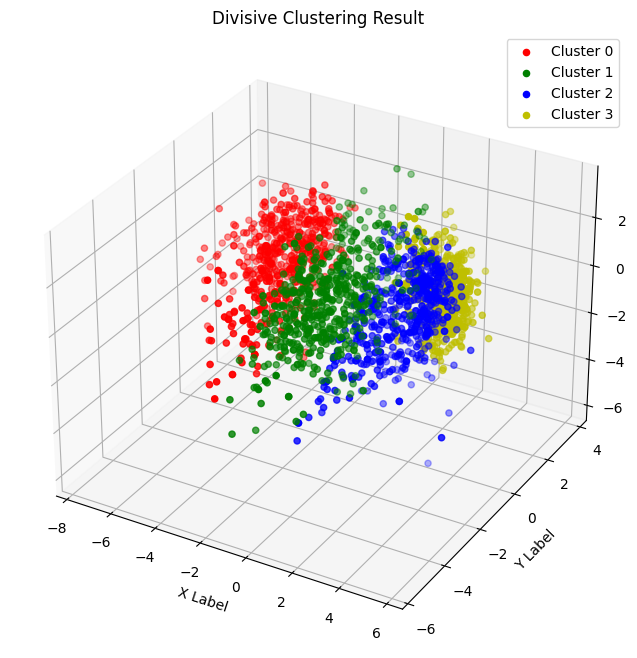

In [25]:
# Plot the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i, cluster_tuple in enumerate(result_dhc):
    cluster_rdd, label = cluster_tuple
    cluster_data = cluster_rdd.collect()
    cluster_data = [[row[0], row[1], row[2]] for row in cluster_data]
    cluster_data = list(zip(*cluster_data))
    ax.scatter(cluster_data[0], cluster_data[1], cluster_data[2], c=colors[i % len(colors)], label=f"Cluster {i}")


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.title('Divisive Clustering Result')
plt.legend()
plt.show()


## AHC

In [ ]:
for i, cluster in enumerate(result_ahc):
  cluster_rdd, label = cluster
  print(f"Cluster {label} (label: {label}) has {cluster_rdd.count()} points")

In [ ]:
cluster_data = []
for i, cluster_tuple in enumerate(result_ahc):
    cluster_rdd, label = cluster_tuple
    cluster_data.extend([(row.tolist(), label) for row in cluster_rdd.collect()])


In [ ]:
cluster_df = spark.createDataFrame(cluster_data, ["features", "cluster"])


In [ ]:
num_features = len(cluster_data[0][0])
df = cluster_df.select([col("features")[i].alias(f"col{i+1}") for i in range(num_features)] + ["cluster"])

TypeError: cannot unpack non-iterable int object

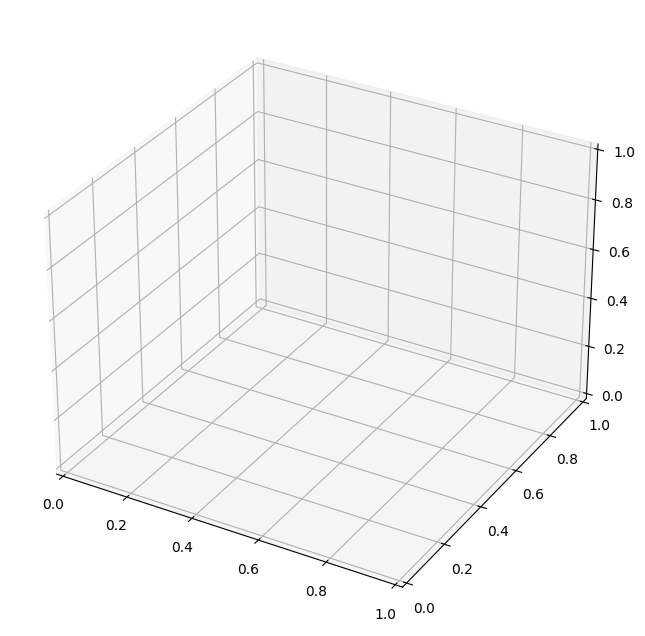

In [75]:
# Plot the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i, cluster_tuple in enumerate(clustered_data):
    cluster_rdd, label = cluster_tuple
    cluster_data = cluster_rdd.collect()
    cluster_data = [[row[0], row[1], row[2]] for row in cluster_data]
    cluster_data = list(zip(*cluster_data))
    ax.scatter(cluster_data[0], cluster_data[1], cluster_data[2], c=colors[i % len(colors)], label=f"Cluster {i}")


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.title('Divisive Clustering Result')
plt.legend()
plt.show()


# HỆ SỐ ĐÁNH GIÁ

In [47]:
from itertools import combinations
import numpy as np
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

In [48]:
def distance(x, y):
    return sum([(a - b) ** 2 for a, b in zip(x, y)]) ** 0.5


In [53]:
def calinski_harabasz_index(rdd_v, cluster_v):
    # Collect all points and their labels on the driver
    points_with_labels = []
    for rdd, label in zip(rdd_v, cluster_v):
        points_with_labels.extend([(point, label) for point in rdd.collect()])

    n = len(points_with_labels)
    k = len(rdd_v)

    # Compute the overall mean of all points
    overall_sum = np.sum([np.array(point) for point, _ in points_with_labels], axis=0)
    overall_mean = overall_sum / n

    def cluster_dispersion(cluster_points):
        if len(cluster_points) == 0:
            return 0.0
        cluster_mean = np.mean([np.array(p) for p in cluster_points], axis=0)
        w_k = sum([np.sum((np.array(p) - cluster_mean) ** 2) for p in cluster_points])
        return w_k

    w_k = sum([cluster_dispersion([p for p, l in points_with_labels if l == label]) for label in set(cluster_v)])

    b_k = sum([
        len([p for p, l in points_with_labels if l == label]) * np.sum((overall_mean - np.mean([np.array(p) for p, l in points_with_labels if l == label], axis=0)) ** 2)
        for label in set(cluster_v)
    ])

    ch_index = (b_k / (k - 1)) / (w_k / (n - k))
    return ch_index


In [54]:
def silhouette_coefficient(rdd_v, cluster_v):
    # Collect all points and their labels on the driver
    points_with_labels = []
    for rdd, label in zip(rdd_v, cluster_v):
        points_with_labels.extend([(point, label) for point in rdd.collect()])

    # Broadcast the points and labels mapping
    cluster_labels = sc.broadcast({point: label for point, label in points_with_labels})

    def compute_silhouette(point):
        point_cluster = cluster_labels.value[point]
        same_cluster_points = [p for p, l in points_with_labels if l == point_cluster]
        a = sum([distance(point, p) for p in same_cluster_points]) / len(same_cluster_points)

        b = float('inf')
        for other_cluster in set(cluster_v):
            if other_cluster != point_cluster:
                other_cluster_points = [p for p, l in points_with_labels if l == other_cluster]
                b = min(b, sum([distance(point, p) for p in other_cluster_points]) / len(other_cluster_points))

        return (b - a) / max(a, b)

    silhouette_scores = [compute_silhouette(point) for point, _ in points_with_labels]
    return sum(silhouette_scores) / len(silhouette_scores)


## DHC

In [69]:
# Extract RDDs and cluster labels into separate lists
rdd_v = [cluster[0] for cluster in result_dhc]
cluster_v = [cluster[1] for cluster in result_dhc]


In [70]:
silhouette_score_DHC = silhouette_coefficient(rdd_v, cluster_v)
ch_index_DHC = calinski_harabasz_index(rdd_v, cluster_v)

In [71]:
print("Divisive Hierarchical Clustering (Eval Metrics):")
print("Silhouette Coefficient :", silhouette_score_DHC)
print("Calinski-Harabasz Index:", ch_index_DHC)

Divisive Hierarchical Clustering (Eval Metrics):
Silhouette Coefficient : 0.30985129394566485
Calinski-Harabasz Index: 1640.7549164975528


## AHC

In [58]:

# Path to your CSV file
csv_file_path = "/content/Data_agg.csv"

In [59]:

# Load data from CSV file
df_agg_loaded = spark.read.csv(csv_file_path, header=True, inferSchema=True)


In [60]:
df_agg_loaded.printSchema()

root
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)
 |-- cluster: integer (nullable = true)



In [85]:
cluster_counts = df_agg_loaded.groupBy("cluster").count().orderBy("cluster")

# Show the counts of each unique value in the 'cluster' column
cluster_counts.show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|    2|
|      2|    2|
|      3|    2|
|      4| 2002|
+-------+-----+



In [63]:
features_df = df_agg_loaded.select("x", "y", "z")
labels_df = df_agg_loaded.select("cluster")

# chuyển df về RDD
features_rdd = features_df.rdd
labels_rdd = labels_df.rdd.map(lambda row: row[0])

In [64]:
# Kết hợp cả Features và label với nhau
combined_rdd = features_rdd.zip(labels_rdd)
clustered_data = combined_rdd.groupBy(lambda x: x[1]).collect()


In [65]:
# Extract RDDs for each cluster and their labels
rdd_v = [sc.parallelize([x[0] for x in cluster[1]]) for cluster in clustered_data]
cluster_v = [cluster[0] for cluster in clustered_data]

In [66]:
silhouette_score = silhouette_coefficient(rdd_v, cluster_v)
ch_index = calinski_harabasz_index(rdd_v, cluster_v)

In [67]:
print("Silhouette Coefficient:", silhouette_score)
print("Calinski-Harabasz Index:", ch_index)

Silhouette Coefficient: 0.1695101794331076
Calinski-Harabasz Index: 0.9461160885532321


# DỪNG SESSION

In [ ]:
spark.stop()